<a href="https://colab.research.google.com/github/nataliachmurak/colourisation/blob/main/cifar_nogan_cielab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#importing cifar 
from matplotlib import pyplot
from keras.datasets import cifar10
from keras import backend as K


#importing keras
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.metrics import AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from keras.callbacks import Callback

#parameters searches
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#colour schemes
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.color import rgb2gray
from skimage.io import imsave, imread
from skimage import io
from skimage.transform import resize


#others
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import math

print('Done!')

Done!


In [15]:
#CIELAB load data method
def load_data():
  (train_X, _), (test_X, _) = cifar10.load_data()
  
  #train data
  train_X = train_X.astype('float32')
  train_X = train_X / 255.0

  X = rgb2lab(train_X)[:,:,:,0]
  Y = rgb2lab(train_X)[:,:,:,1:]
  Y /= 128

  X = np.expand_dims(X,3)
  
  print(X.shape)
  print(Y.shape)

  print(f'Train_X shape: {train_X.shape}')
  
  print(f'Input data is in range {X.min()} to {X.max()}.')
  print(f'Ground truth data is in range {Y.min()} to {Y.max()}.')

  #test data
  test_X = test_X.astype('float32')
  test_X = test_X / 255.0
  groundTruth = test_X

  testX = rgb2lab(test_X)[:,:,:,0]
  testY = rgb2lab(test_X)[:,:,:,1:]
  testY /= 128

  testX = np.expand_dims(testX, 3)

  print(testX.shape)
  print(testY.shape)
  
  print(f'Test input data is in range {testX.min()} to {testX.max()}.')
  print(f'Test ground truth data is in range {testY.min()} to {testY.max()}.')
  
  return X, Y, testX, testY, groundTruth 

print('Done!')

Done!


In [ ]:
def plots(history):
  
  #plot the loss curves for test and train data
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='red', label='test')
  
  #plot the accuracy for test and train data
  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='red', label='test')

  pyplot.show()

print('Done')


Done


In [16]:
#building the model 
def create_model():
  model = Sequential()
  model.add(InputLayer(input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=1))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same',strides =1))
  model.add(Conv2D(64, (5, 5), activation='relu', padding='same',strides =1))
  model.add(Conv2D(64, (5, 5), activation='relu', padding='same', strides =1))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same',strides =1))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same',strides =1))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same',strides =1))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same',strides =1))

  
   
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  
#model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), 'accuracy'])
  model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), 'accuracy'])
  return model



model = create_model()
print(model.summary())
print('Done!')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
 model.save('/content/drive/My Drive/colourisation_model.h5')

In [ ]:
#compiling the model
#history = model.compile(optimizer='Adam', loss='mse',  metrics=['accuracy'])

#model.compile(optimizer='Adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), 'accuracy'])
#print('Done!')

In [17]:
X, Y, testX, testY, groundTruth = load_data()



(50000, 32, 32, 1)
(50000, 32, 32, 2)
Train_X shape: (50000, 32, 32, 3)
Input data is in range 0.0 to 100.0.
Ground truth data is in range -0.8426351578648038 to 0.7674457333055711.
(10000, 32, 32, 1)
(10000, 32, 32, 2)
Test input data is in range 0.0 to 100.0.
Test ground truth data is in range -0.8025176571043288 to 0.7333400204446777.


In [ ]:
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
#learn_rate = [0.0001, 0.001, 0.01, 0.1]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
batch_size = [8, 16, 32, 64, 128, 256]
epochs = [10, 50, 100, 150]
#param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs, learn_rate=learn_rate, momentum=momentum)
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter = 20)
#grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = random_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from keras.models import save_model, load_model

model = load_model('/content/drive/MyDrive/colourisation_model.h5')

In [18]:

history = model.fit(X, Y, batch_size=32, epochs=100, validation_data=(testX, testY))
#model.fit(X, Y, batch_size=128, epochs=50)
#history = model.fit(X, Y, batch_size=128, epochs=50)

#pyplot.plot(history.history['mean_squared_error'])
#pyplot.plot(history.history['accuracy'])
pyplot.show()
print('Done!')

Epoch 1/100
1563/1563 [==============================] - 57s 35ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - accuracy: 0.6261 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_accuracy: 0.6239
Epoch 2/100
1563/1563 [==============================] - 54s 35ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - accuracy: 0.6304 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_accuracy: 0.6239
Epoch 3/100
1563/1563 [==============================] - 54s 35ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - accuracy: 0.6296 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_accuracy: 0.6239
Epoch 4/100
 223/1563 [===>..........................] - ETA: 43s - loss: 0.0111 - mean_squared_error: 0.0111 - accuracy: 0.6281

KeyboardInterrupt: ignored

In [8]:
print("Evaluate on test data")
model.evaluate(testX, testY, batch_size=32, verbose=1)

output = model.predict(testX[:10000])
output *= 128
print('Done!')
print(output.shape)



Evaluate on test data
313/313 [==============================] - 2s 7ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - accuracy: 0.6239
Done!
(10000, 32, 32, 2)


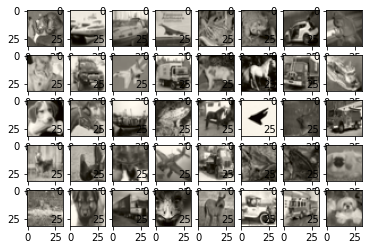

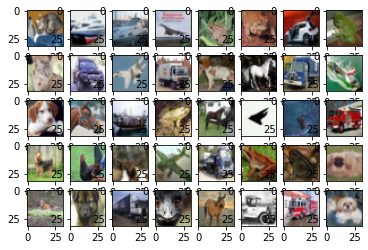

In [9]:
for i in range(40):
  cur = np.zeros((32, 32, 3))
  cur[:,:,0] = testX[i][:,:,0]
  cur[:,:,1:] = output[i]
  final = lab2rgb(cur)
  pyplot.subplot(5, 8, i+1)
  pyplot.imshow(final)
pyplot.show()

for i in range(40):
  pyplot.subplot(5, 8, i+1)
  pyplot.imshow(groundTruth[i])
pyplot.show()  

In [12]:
final2 = np.zeros((10000, 32, 32, 3))

for i in range(10000):
  cur = np.zeros((32, 32, 3))
  cur[:,:,0] = testX[i][:,:,0]
  cur[:,:,1:] = output[i]
  final = lab2rgb(cur)
  final2[i,:,:,:] = final

print(final2.shape)

(10000, 32, 32, 3)


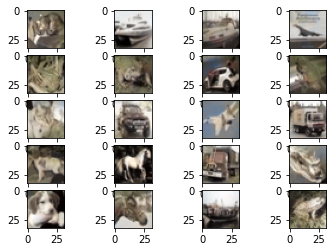

In [13]:
for i in range(20):
  pyplot.subplot(5, 4, i+1)
  pyplot.imshow(final2[i])
pyplot.show()  

In [ ]:
import pandas as pd

print(final2.shape)
print(groundTruth.shape)

print('PSNR metrics - SUM AND MEAN')
print('Test data')
psnr_array =[]

for i in range(10000):
  psnr = tf.image.psnr(groundTruth[i], final2[i], max_val=255)
  psnr_array.append(psnr)

sum = 0 
for j in range(0, len(psnr_array)):
  #print(psnr_array[j])
  sum += psnr_array[j]

mean = sum / len(psnr_array)
print(sum)
print(mean)





  

(10000, 32, 32, 3)
(10000, 32, 32, 3)
PSNR metrics - SUM AND MEAN
Test data
tf.Tensor(539681.44, shape=(), dtype=float32)
tf.Tensor(53.968143, shape=(), dtype=float32)


In [ ]:
#IMPORTANT!!!!! final2 for CIELAB
#OUTPUT for RGB because we do not have to put channels back together
#groundtruth the same

print('SSIM - Sum and mean')
ssim_array = []
for i in range(1000):
  im1 = tf.image.convert_image_dtype(groundTruth[i], tf.float32)
  im2 = tf.image.convert_image_dtype(final2[i], tf.float32)
  ssim = tf.image.ssim(im1, im1, max_val=1.0)
  ssim_array.append(ssim)

sum = 0 
for i in range(0, len(ssim_array)):
  #print(ssim_array[i])
  sum = sum + ssim_array[i]

mean = sum / len(ssim_array)
print(sum)
print(mean)

SSIM - Sum and mean
tf.Tensor(1000.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:


#IMPORTANT!!!!! final2 for CIELAB
#OUTPUT for RGB because we do not have to put channels back together
#groundtruth the same

print()
sad_array = []
for i in range(10000):
  sad = np.sum(abs(groundTruth[i] - final2[i]))
  sad_array.append(sad)

print(len(sad_array))  
sum = 0 
for i in range(0, len(sad_array)):
  #print(sad_array[i])
  sum = sum + sad_array[i]


mean = sum / len(sad_array)
print(sum)
print(mean)



  

  


10000
14640049.849651035
1464.0049849651034
